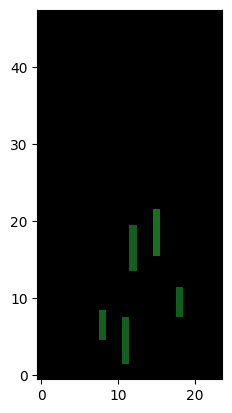

In [11]:
# https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

W = 24
H = W * 2

# Create a black image
img = np.zeros((H, W, 3), np.uint8)

# Draw a diagonal blue line with thickness of 5 px
# cv2.line(img, (0, 0), (W-1, H-1), (255, 0, 0), 5)

for _ in range(5):
    bx = random.randint(2, W-3)
    by = random.randint(2, 24-3)
    bh = random.randint(3, 5)
    
    color = (
        random.randint(15, 25),
        random.randint(80, 125),
        random.randint(25, 35),
    )
    
    cv2.line(img, (bx, by), (bx, by+bh), color, 1)
    


plt.imshow(img, origin='lower')

In [48]:
import engine.images as img

In [49]:
import arcade

img1 = img.load_bitmap("./assets/debug/grass_water_basic_00x001x1x.bmp")
img2 = img.load_bitmap("./assets/debug/painted.bmp")

spt1 = arcade.Sprite(texture=img.bitmap_to_texture(img1))
spt2 = arcade.Sprite(texture=img.bitmap_to_texture(img2), image_x=50)

arcade.open_window(600, 600, "Drawing Example")
spt1.draw()
spt2.draw()
arcade.run()

In [50]:
def combine_bmp(bot: cv2.typing.MatLike, top: cv2.typing.MatLike, mask: cv2.typing.MatLike, rotate: int = 0) -> cv2.typing.MatLike:
    if rotate != 0 and rotate % 90 == 0:
        rotate = (rotate + 360) % 360
        mask = cv2.rotate(mask, rotations.get(rotate))
    bot_mask = cv2.bitwise_and(bot, cv2.bitwise_not(mask))
    top_mask = cv2.bitwise_and(top, mask)
    return bot_mask + top_mask

def combine_bmp_path(bot: str, top: str, mask: str, rotate: int = 0) -> cv2.typing.MatLike:
    mask_nrm = cv2.imread(mask)
    bot_img = cv2.imread(bot)
    top_img = cv2.imread(top)
    return combine_bmp(bot_img, top_img, mask_nrm, rotate)


def has_slots(mask: str) -> bool:
    for idx in [0, 2, 6, 8]:
        val = mask[idx]
        if val == '0':
            return True
    return False

In [1]:
import cv2
import engine.images as img

mask = img.load_image("./assets/debug/pngs/mask.png")
base = img.load_image("./assets/debug/pngs/base.png")
over = img.load_image("./assets/debug/pngs/over.png")

result = img.combine_images(base, over, mask)
cv2.imwrite("./assets/debug/pngs/result.png", result)

True

In [42]:
# m1 = cv2.imread("./assets/masks/processed/basic_101000101.bmp")
# m2 = cv2.imread("./assets/masks/processed/basic_x1x000000.bmp")
# m2 = cv2.rotate(m2, cv2.ROTATE_90_COUNTERCLOCKWISE)
# m3 = m1 + m2
# cv2.imwrite("./assets/debug/m1_m2r.bmp", m3)
# print(define_mask(m3, True))

# m4 = m3
# m4[23, 23] = (255, 0, 0)
# cv2.imwrite("./assets/debug/painted.bmp", m4)

In [2]:
import os, shutil, cv2
from engine.images import define_mask, rotate_bitmap

def process_masks(mask_type: str):
    shutil.rmtree("./assets/masks/processed/")
    os.mkdir("./assets/masks/processed/")
    
    print(f"{mask_type=}")
    
    mask_names = [bm for bm in os.listdir("./assets/masks/") if mask_type in bm]
    print(f"{mask_names=}")
    
    mask_paths = [f"./assets/masks/{bm}" for bm in mask_names]
    print(f"{mask_paths=}")
    
    mask_paths_tip = [m for m in mask_paths if '_tip_' in m][0]
    print(f"{mask_paths_tip=}")
    
    # Tip masks
    tip_masks: dict[str, cv2.typing.MatLike] = {}
    mask_og = cv2.imread(mask_paths_tip) # Original tip piece
    
    # Creates the 4 original rotations for 1 corner
    for rotation in [0, 90, 180, 270]:
        mask = rotate_bitmap(mask_og, rotation)
        tip_masks[define_mask(mask)] = mask
        print(f"{define_mask(mask)=}")
    
    # Two corners            1                        1
    tip_masks["101000000"] = tip_masks["100000000"] + tip_masks["001000000"]
    tip_masks["100000100"] = tip_masks["100000000"] + tip_masks["000000100"]
    tip_masks["100000001"] = tip_masks["100000000"] + tip_masks["000000001"]
    tip_masks["001000100"] = tip_masks["001000000"] + tip_masks["000000100"]
    tip_masks["001000001"] = tip_masks["001000000"] + tip_masks["000000001"]
    tip_masks["000000101"] = tip_masks["000000100"] + tip_masks["000000001"]
    
    # Three corners          2                        1
    tip_masks["101000100"] = tip_masks["101000000"] + tip_masks["000000100"]
    tip_masks["101000001"] = tip_masks["101000000"] + tip_masks["000000001"]
    tip_masks["100000101"] = tip_masks["100000100"] + tip_masks["000000001"]
    tip_masks["001000101"] = tip_masks["001000100"] + tip_masks["000000001"]
    
    # Four corners           2                        2
    tip_masks["101000101"] = tip_masks["101000000"] + tip_masks["000000101"]
    
    del mask_og, mask
    
    # Other masks
    other_masks: dict[str, cv2.typing.MatLike] = {}
    for mask_path in mask_paths:
        mask_og = cv2.imread(mask_path) # Original mask
        
        # Creates the 4 rotations for this mask
        for rotation in [0, 90, 180, 270]:
            mask = rotate_bitmap(mask_og, rotation)
            other_masks[define_mask(mask)] = mask
            print(f"{define_mask(mask)=}")
            
            for tip_mask in tip_masks.values():
                combined_mask = mask + tip_mask
                other_masks[define_mask(combined_mask)] = combined_mask
                print(f"{define_mask(combined_mask)=}")
    
    # Saves the masks
    masks = tip_masks | other_masks
    for mask_hash, mask_data in masks.items():
        cv2.imwrite(f"./assets/masks/processed/{mask_type}_{mask_hash}.bmp", mask_data)

process_masks("basic")

mask_type='basic'
mask_names=['basic_all_x1x101x1x.bmp', 'basic_corn_x1x100x00.bmp', 'basic_end_x0x101x1x.bmp', 'basic_one_x1x000000.bmp', 'basic_tip_100000000.bmp', 'basic_two_x1x000x1x.bmp']
mask_paths=['./assets/masks/basic_all_x1x101x1x.bmp', './assets/masks/basic_corn_x1x100x00.bmp', './assets/masks/basic_end_x0x101x1x.bmp', './assets/masks/basic_one_x1x000000.bmp', './assets/masks/basic_tip_100000000.bmp', './assets/masks/basic_two_x1x000x1x.bmp']
mask_paths_tip='./assets/masks/basic_tip_100000000.bmp'
define_mask(mask)='100000000'
define_mask(mask)='000000100'
define_mask(mask)='000000001'
define_mask(mask)='001000000'
define_mask(mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mask)='x1x101x1x'
define_mask(combined_mas

In [ ]:
mask = cv2.imread("./assets/masks/corner_hard_NW_0.bmp")
mask2 = cv2.imread("./assets/masks/corner_tip_NW_0.bmp")
mask2 = cv2.rotate(mask2, cv2.ROTATE_180)
masks = mask + mask2
cv2.imwrite("./assets/debug/masks.bmp", masks)
print(define_mask(masks, True))

In [ ]:
def process_transitions(base: str, over: str):
    masks = [f"./assets/masks/{t}" for t in os.listdir("./assets/masks/")]
    print(masks)
    
    base_type = base.split('/')[-1].split('.')[0].split('_')[0]
    over_type = over.split('/')[-1].split('.')[0].split('_')[0]
    print(f"{base_type=} {over_type=}")
    
    for mask in masks:
        mask_type, mask_class, mask_dir, _ = mask.split('/')[-1].split('.')[0].split('_')
        print(f"{mask_type=} {mask_class=} {mask_dir=}")
        for rotation in [0, 90, 180, 270]:
            new_dir = rot_conv.get(mask_dir).get(rotation)
            print(f"{mask=} {rotation=} {new_dir=}")
            
            trans = combine_bmp_path(base, over, mask, rotation)
            cv2.imwrite(f"./assets/transitions/{base_type}_{over_type}_{mask_class}_{new_dir}_0.bmp", trans)

process_transitions("./assets/ground/water_normal_0.bmp", "./assets/ground/grass_normal_0.bmp")

In [54]:
test_tiles = [
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],
    [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ],
    [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ],
    [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ],
    [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ],
    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],
]

def slice_tiles(tile_matrix) -> dict[tuple, str]:
    subtiles = {}
    tile_order = [ # ORDER: NW N NE W X E SW S SE
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1), ( 0, 0), ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    width = len(tile_matrix[0])
    height = len(tile_matrix)
    
    for row in range(height):
        for col in range(width):
            tslice = []
            for r, c in tile_order:
                row_off, col_off = row + r, col + c
                if row_off < 0 or row_off >= height or col_off < 0 or col_off >= width:
                    value = '?'
                else:
                    value = str(tile_matrix[row_off][col_off])
                tslice.append(value)
            subtiles[(row, col)] = ''.join(tslice)
    return subtiles

subtiles = slice_tiles(test_tiles)
subtiles

{(0, 0): '????00?01',
 (0, 1): '???001011',
 (0, 2): '???011110',
 (0, 3): '???111101',
 (0, 4): '???111010',
 (0, 5): '???111101',
 (0, 6): '???111011',
 (0, 7): '???111110',
 (0, 8): '???111101',
 (0, 9): '???111011',
 (0, 10): '???111110',
 (0, 11): '???111100',
 (0, 12): '???111000',
 (0, 13): '???111000',
 (0, 14): '???111000',
 (0, 15): '???111000',
 (0, 16): '???111000',
 (0, 17): '???111001',
 (0, 18): '???11?01?',
 (1, 0): '?00?01?11',
 (1, 1): '001011111',
 (1, 2): '011110110',
 (1, 3): '111101101',
 (1, 4): '111010011',
 (1, 5): '111101111',
 (1, 6): '111011110',
 (1, 7): '111110100',
 (1, 8): '111101001',
 (1, 9): '111011011',
 (1, 10): '111110110',
 (1, 11): '111100101',
 (1, 12): '111000011',
 (1, 13): '111000111',
 (1, 14): '111000110',
 (1, 15): '111000100',
 (1, 16): '111000000',
 (1, 17): '111001000',
 (1, 18): '11?01?00?',
 (2, 0): '?01?11?10',
 (2, 1): '011111100',
 (2, 2): '110110000',
 (2, 3): '101101000',
 (2, 4): '010011000',
 (2, 5): '101111001',
 (2, 6): '0111

In [ ]:
done = combine_bmp_path("./assets/ground/water_normal_0.bmp", "./assets/ground/grass_normal_0.bmp", "./assets/masks/smile_mask.bmp")
cv2.imwrite("./assets/transitions/test.bmp", done)

In [ ]:
done = combine_bmp_path("./assets/ground/water_normal_0.bmp", "./assets/ground/grass_normal_0.bmp", "./assets/masks/corner_open_NW_0.bmp")
cv2.imwrite("./assets/transitions/grass_water_edge_NW_0.bmp", done)

In [ ]:
import os
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def clear_asset(asset: str):
    folder_path = f"./assets/{asset}"
    shutil.rmtree(folder_path)
    os.mkdir(folder_path)

In [ ]:
WIDTH, HEIGHT = 24, 24
REPEAT = 2

SHOW = True
SAVE = True

OTHER  = (15, 20)
OTHER2 = (20, 25)

MODES = {
    "light"  : (75, 95),
    "normal" : (60, 80),
    "dark"   : (45, 65),
}

if SAVE:
    clear_asset("ground")

In [ ]:
for mode_idx, (mode, vals) in enumerate(MODES.items()):
    for idx in range(REPEAT):
        base_img = np.zeros((WIDTH, HEIGHT, 3), dtype=np.uint8)
        
        for i in range(WIDTH):
            for j in range(HEIGHT):
                red = random.randint(*OTHER)
                grn = random.randint(*vals)
                blu = random.randint(*OTHER)
                
                if random.random() < 0.10:
                    red += random.randint(20, 30)
                    grn += random.randint(10, 20)
                if random.random() < 0.10:
                    red -= random.randint(5, 10)
                    grn -= random.randint(5, 10)
                base_img[i, j] = (red, grn, blu)
        
        if SAVE:
            Image.fromarray(base_img).save(f"./assets/ground/grass_{mode}_{idx}.bmp")
        if SHOW:
            plt.subplot(3, REPEAT, mode_idx*REPEAT + idx+1)
            plt.imshow(base_img)

In [ ]:
for mode_idx, (mode, vals) in enumerate(MODES.items()):
    for idx in range(REPEAT):
        base_img = np.zeros((WIDTH, HEIGHT, 3), dtype=np.uint8)
        
        for i in range(WIDTH):
            for j in range(HEIGHT):
                red = random.randint(*OTHER2) + 0
                grn = random.randint(*OTHER2) + 10
                blu = random.randint(*vals) + 20
                base_img[i, j] = (red, grn, blu)
        
        for row in range(HEIGHT):
            if random.random() < 1/3:
                size = random.randint(3, 5)
                start = random.randint(0, WIDTH-size)
                tri = [size//2 + 1 - abs(x) for x in range(-size//2 + 1, size//2 + 1)]
                for t, x in enumerate(range(start, start+size)):
                    toff = tri[t]
                    base_img[row, x] += random.randint(0, 5) + (toff*3)
        
        if SAVE:
            Image.fromarray(base_img).save(f"./assets/ground/water_{mode}_{idx}.bmp")
        if SHOW:
            plt.subplot(3, REPEAT, mode_idx*REPEAT + idx+1)
            plt.imshow(base_img)

In [ ]:
for mode_idx, (mode, vals) in enumerate(MODES.items()):
    for idx in range(REPEAT):
        base_img = np.zeros((WIDTH, HEIGHT, 3), dtype=np.uint8)
        
        for i in range(WIDTH):
            for j in range(HEIGHT):
                red = random.randint(*vals) * 0.90
                grn = random.randint(*vals) * 0.50
                blu = random.randint(*OTHER)
                
                if random.random() < 0.20:
                    gry = (red + grn + blu) / 3
                    red += gry // 6
                    grn += gry // 6
                    blu += gry // 6
                base_img[i, j] = (red, grn, blu)
        
        if SAVE:
            Image.fromarray(base_img).save(f"./assets/ground/dirt_{mode}_{idx}.bmp")
        if SHOW:
            plt.subplot(3, REPEAT, mode_idx*REPEAT + idx+1)
            plt.imshow(base_img)